# Imports + Data Loading

In [1]:
import matplotlib.pyplot as plt
import mmh3
import numpy as np
import pandas as pd
import sys
import time

In [2]:
def load_data():
    sequences = pd.read_csv("genomes.csv").set_index("NCBI ID")
    print("Headers:", sequences.columns.values)
    print("Done loading data")
    return sequences

# Helper Functions

## LSH and Jaccard Functions

In [3]:
def jaccard_index(kmers1, kmers2):
    # Returns Jaccard index based on given kmers
    # Jaccard index computed as intersection / union between sets of kmers
    kmers1 = set(kmers1)
    kmers2 = set(kmers2)
    
    intersection = len(kmers1.intersection(kmers2))
    union = len(kmers1.union(kmers2))
    
    return intersection / union

def compute_jaccard_similarities(candidate_pairs, sequence_to_kmers):
    
    sims = []
    
    start_time = time.time()
    for pair in candidate_pairs:
        sims.append(jaccard_index(sequence_to_kmers[pair[0]], sequence_to_kmers[pair[1]]))
    elapsed_time = time.time() - start_time
    
    return sims, elapsed_time

def hash_kmer(kmer, seed=42):
    return mmh3.hash(kmer, seed)

def generate_kmers(sequences, k):
    sequence_to_kmers = {}  # map from NCBI_ID to set of k-mers in that sequence
    all_kmers = set()

    for index, row in sequences.iterrows():
        ncbi_id = index
        sequence = row["Sequence"]
        kmers = []
        # Create k-mers
        i = 0
        while i + k < len(sequence):
            kmer = sequence[i : i + k]
            kmers.append(kmer)
            all_kmers.add(kmer)
            i += 3
        sequence_to_kmers[ncbi_id] = kmers

    print("Done generating", str(len(all_kmers)), "kmers")
    
    return sequence_to_kmers, all_kmers

def compute_signature_matrix(sequence_to_kmers, num_hashes):
    signatures = []

    start_time = time.time()
    for sequence,kmers in sequence_to_kmers.items():
        signature_list = []

        for index in range(num_hashes):
            minimum = sys.maxsize
            for kmer in kmers:
                hashed = hash_kmer(kmer,index)
                if hashed < minimum:
                    minimum = hashed
            signature_list.append(minimum)

        signatures.append(signature_list)
    elapsed_time = time.time() - start_time

    print("Done computing signature matrix")
    
    return signatures, elapsed_time
    
    
def lsh_candidate_pairs(sequence_to_kmers, b, r):
    sequence_ids = list(sequence_to_kmers.keys())

    hash_tables = []
    candidate_pairs = set()

    start_time = time.time()
    for band in range(1, b + 1):
        hash_table = {}
        for col in range(len(sequence_ids)):
            band_sig = signatures[col][(band - 1) * r : band * r] 

            hash_value = mmh3.hash(str(band_sig), 42, signed=False) 
            bucket_num = hash_value % num_buckets        

            if bucket_num not in hash_table:
                hash_table[bucket_num] = set()

            hash_table[bucket_num].add(sequence_ids[col])

        for bucket_num, sequences in hash_table.items():
            for id1 in sequences:
                for id2 in sequences:
                    if id1 != id2:
                        candidate_pairs.add(tuple(sorted((id1, id2))))

        hash_tables.append(hash_table)
    
    elapsed_time = time.time() - start_time

    print("Done generating", len(candidate_pairs), "candidate pairs")
    
    return candidate_pairs, hash_tables, elapsed_time
    

def all_candidate_pairs(sequence_to_kmers, threshold):
    candidate_pairs = set()
    jaccard_similarities = []
    
    start_time = time.time()
    for id1 in sequence_to_kmers.keys():
        for id2 in sequence_to_kmers.keys():
            if id1 != id2:
                jaccard_similarity = jaccard_index(sequence_to_kmers[id1], sequence_to_kmers[id2])
                if jaccard_similarity >= threshold:
                    candidate_pairs.add(tuple(sorted((id1, id2))))
                    jaccard_similarities.append(jaccard_similarity)
    elapsed_time = time.time() - start_time

    print("Done generating", len(candidate_pairs), "candidate pairs")
    
    return candidate_pairs, jaccard_similarities, elapsed_time

## Plotting Functions

In [4]:
# Plots probability of candidate pairs given different pairs of b and r values
def plot_probability_of_candidate_pair(b_values, r_values, title):
    similarities = np.arange(0.0, 1.01, 0.01)
    probabilities = []
    similarity_thresholds = []

    labels = ["".join(["b=", str(b_values[i]), ", r=", str(r_values[i])]) for i in range(len(b_values))]

    for i in range(len(b_values)):
        b = b_values[i]
        r = r_values[i]
        for t in similarities:
            p = 1 - (1 - t ** r) ** b
            probabilities.append(p)    
        plt.plot(similarities, probabilities, label=labels[i])
        probabilities = []
        similarity_thresholds.append((1 / b) ** (1 / r))
    
    locs = [0.5 for i in range((len(b_values)))]
    for t in similarity_thresholds:
        plt.axvline(x=t, c='gray', alpha=0.5)
    
    plt.title(title)
    plt.xlabel("Similarity between 2 sequences")
    plt.ylabel("Probability of 2 sequences sharing bucket")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
# Plots histogram of jaccard similarities of candidate pairs generated by LSH for a given b and r
def plot_histogram_of_jaccard_similarities(sequence_to_kmers, b, r):
    signatures, sig_matrix_time = compute_signature_matrix(sequence_to_kmers, b * r)
    candidate_pairs, hash_tables, cand_pair_time = lsh_candidate_pairs(sequence_to_kmers, b, r)
    jaccard_similarities, jacc_sim_time = compute_jaccard_similarities(candidate_pairs, sequence_to_kmers)
    
    plt.title("Distribution of Jaccard Similarity of Candidate Pairs for LSH with b=" + str(b) + ", r=" + str(r))
    plt.xlabel("Jaccard Similarity of Candidate Pairs")
    plt.ylabel("Count")
    plt.hist(jaccard_similarities)
    plt.show()

# Generates table that contains information about time complexity as well as
# number of candidate pairs generated, average Jaccard similarity, maximum
# Jaccard similarity, and minimum Jaccard similarity for the candidate pairs
# for different b and r values that result in the given threshold.
def make_time_complexity_table(sequence_to_kmers, threshold = 0.9):

    # b-r value pairs such that threshold calculated by (1/b)^(1/r) is approximately threshold (0.9)
    b_values = [2, 3, 5, 10, 24, 50, 100]
    r_values = [7, 10, 15, 22, 30, 37, 44]
    
    sig_matrix_times = []
    cand_pair_times = []
    jacc_sim_times = []
    
    num_pairs = []
    avg_sims = []
    max_sims = []
    min_sims = []
    
    plot_probability_of_candidate_pair(b_values, r_values, "Probability of Candidate Pairs with threshold=0.9")
    
    for i in range(len(b_values)):
        print(i)
        
        b = b_values[i]
        r = r_values[i]
        
        signatures, sig_matrix_time = compute_signature_matrix(sequence_to_kmers, b * r)
        candidate_pairs, hash_tables, cand_pair_time = lsh_candidate_pairs(sequence_to_kmers, b, r)
        jaccard_similarities, jacc_sim_time = compute_jaccard_similarities(candidate_pairs, sequence_to_kmers)
        jaccard_similarities = np.array(jaccard_similarities)
        
        sig_matrix_times.append(sig_matrix_time)
        cand_pair_times.append(cand_pair_time)
        jacc_sim_times.append(jacc_sim_time)
        
        num_pairs.append(len(candidate_pairs))
        
        
        avg_sims.append(np.average(jaccard_similarities))
        max_sims.append(np.max(jaccard_similarities))
        min_sims.append(np.min(jaccard_similarities))
        
    
    table = pd.DataFrame(list(zip(sig_matrix_times, cand_pair_times, jacc_sim_times, num_pairs, avg_sims, max_sims, min_sims)),
                         index = ["".join(["b=", str(b_values[i]), ", r=", str(r_values[i])]) for i in range(len(b_values))],
                         columns =['Runtime for Generating Signature Matrix', 'Runtime for Getting Candidate Pairs', 'Runtime for Getting Candidate Pairs', 'Number of Candidate Pairs', 'Average Jaccard Similarity of Candidate Pairs', 'Maximum Jaccard Similarity of Candidate Pairs', 'Minimum Jaccard Similarity of Candidate Pairs']) 
        
    return table

    
def visualize(sequence_to_kmers):
    plot_probability_of_candidate_pair(b_values=[2, 4, 8, 10, 25, 50, 100],
                                       r_values=[100, 50, 25, 20, 8, 4, 2],
                                       title="Probability of Candidate Pairs with num_hashes=200")
    plot_probability_of_candidate_pair(b_values=[2, 4, 5, 10, 20, 25, 50],
                                       r_values=[50, 25, 20, 10, 5, 4, 2],
                                       title="Probability of Candidate Pairs with num_hashes=100")
    plot_probability_of_candidate_pair(b_values=[1, 2, 5, 10, 20, 30, 60],
                                       r_values=[60, 30, 12, 6, 3, 2, 1],
                                       title="Probability of Candidate Pairs with num_hashes=60")
    
    plot_histogram_of_jaccard_similarities(sequence_to_kmers, b=2, r=70)
    
    make_time_complexity_table(sequence_to_kmers)

# Main Analysis

Headers: ['FASTA description' 'Genome collection date' 'Locallity' 'Sequence'
 'YP_009725297.1' 'YP_009725298.1' 'YP_009725299.1' 'YP_009725300.1'
 'YP_009725301.1' 'YP_009725302.1' 'YP_009725303.1' 'YP_009725304.1'
 'YP_009725305.1']
Done loading data
Done generating 33101 kmers
Done computing signature matrix
Done generating 15947 candidate pairs


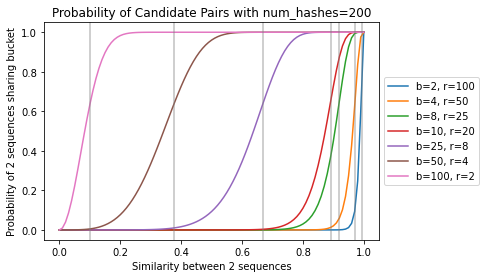

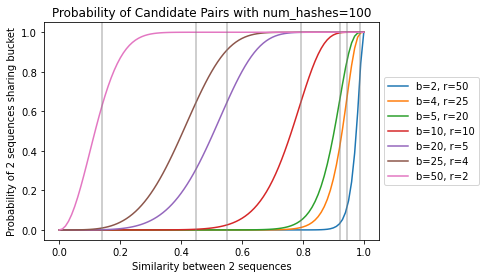

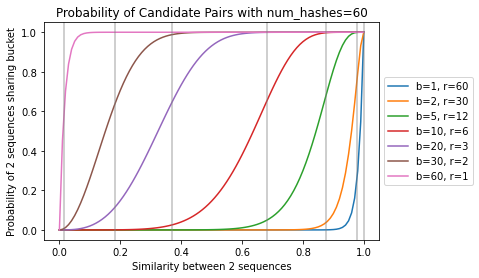

Done computing signature matrix
Done generating 16241 candidate pairs


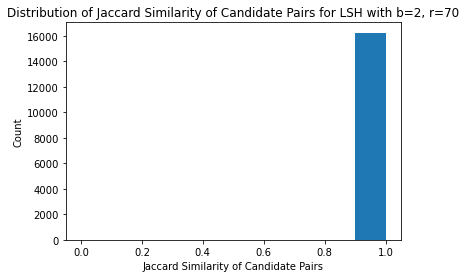

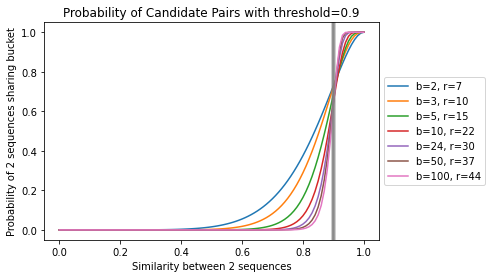

0
Done computing signature matrix
Done generating 26019 candidate pairs
1
Done computing signature matrix
Done generating 26131 candidate pairs
2
Done computing signature matrix
Done generating 26111 candidate pairs
3
Done computing signature matrix
Done generating 67161 candidate pairs
4
Done computing signature matrix
Done generating 67161 candidate pairs
5
Done computing signature matrix
Done generating 67161 candidate pairs
6
Done computing signature matrix
Done generating 67161 candidate pairs
Done generating 26131 candidate pairs
(367, 10000)


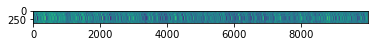

In [5]:
# def main():
# Hyperparameters
k = 15

b = 2
r = 50
num_hashes = b * r

num_buckets = 400 # number of buckets in hash table for LSH

# LSH
sequences = load_data()
sequence_to_kmers, all_kmers = generate_kmers(sequences, k)
signatures, sig_matrix_time = compute_signature_matrix(sequence_to_kmers, num_hashes)
candidate_pairs, hash_tables, cand_pair_time = lsh_candidate_pairs(sequence_to_kmers, b, r)
visualize(sequence_to_kmers)

# Deterministic algorithm
candidate_pairs, jaccard_similarities, cand_pair_time = all_candidate_pairs(sequence_to_kmers, threshold=0.9)
jaccard_similarities = np.array(jaccard_similarities)

## Visualization of Raw Sequences

In [ ]:
# Visualizes of first 20000 nucleotides of sequences: As we can see all of the seqeunces are quite similar, and this explains above results.
s = list(sequences['Sequence'])

seq_matrix = [[1 if char == 'A' else 2 if char == 'T' else 3 if char == 'C' else 4 for char in seq[0:20000]] for seq in s]
seq_matrix = np.array([np.array(xi, dtype=float) for xi in seq_matrix])
print(seq_matrix.shape)
plt.imshow(seq_matrix, aspect='auto')
# plt.figure(figsize=(77760,36000))

